# Тестирование алгоритмов кластеризации

In [6]:
import sys
import os
current_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Анализ данных

In [8]:
wine=pd.read_csv('../data/wine-clustering.csv', sep=',')

Применим метод главных компонент для примерного понимания числа и структуры кластеров

In [57]:
from sklearn.decomposition import PCA

In [58]:
d=(wine-wine.mean())/wine.std()
d=d.to_numpy()#Стандартизация
pca = PCA(n_components=2)
y=pca.fit_transform(d)

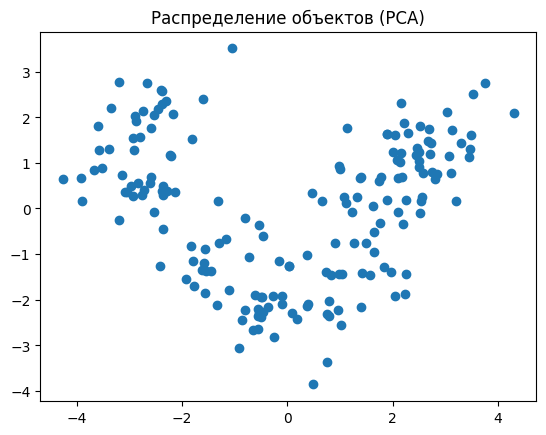

In [59]:
plt.scatter(y[:,0],y[:,1])
plt.title('Распределение объектов (PCA)')
plt.show()

По графику можно заметить, что кластеров, скорее всего, 3. Их структура - кластеры с центром, возможно, соединённые перемычками

# Тестирование иерархического алгоритма кластеризации

In [60]:
from hierarchical import Hierarchical_clusterer

In [61]:
hc=Hierarchical_clusterer()

In [62]:
start = time.time()
hc.fit(wine) #Обучение
end = time.time()
print("Время выполнения реализованного алгоритма:",
      (end-start) * 10**3, "ms")

Время выполнения реализованного алгоритма: 2397.251844406128 ms


Рассмотрим дендрограмму

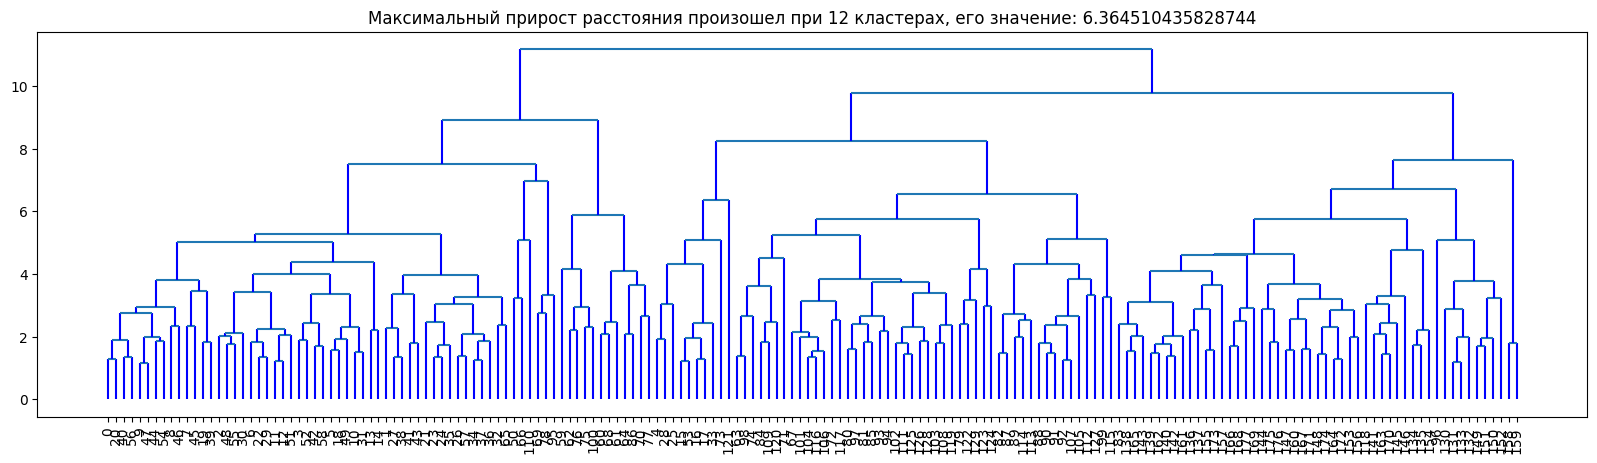

In [63]:
hc.draw_dendrogram()

Несмотря на то, что максимальный прирост расстояния произошёл при 12 кластерах, видно, что оптимальное число кластеров - 3

In [64]:
from sklearn.cluster import AgglomerativeClustering
from utils.preparation import standartize_data
d=standartize_data(wine)
cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete',compute_distances=True)

In [65]:
start = time.time()
cl=cluster.fit_predict(np.array(d))
end = time.time()
print("Время выполнения эталонной реализации:",
      (end-start) * 10**3, "ms")

Время выполнения эталонной реализации: 0.3330707550048828 ms


Для сравнения результатов работы алгоритмов используем матрицу сопряжённости:

In [66]:
p=pd.crosstab(index = np.array(hc.predict(3)), columns = cl)
p.index = ['Cluster 0', 'Cluster 1','Cluster 2']
p.columns = [ 'Cluster 0', 'Cluster 1','Cluster 2']
p

,Cluster 0,Cluster 1,Cluster 2
Cluster 0,69,0,0
Cluster 1,0,58,0
Cluster 2,0,0,51


Рассмотрим метрики кластеризации (одинаковые, т.к. составы кластеров полностью совпали):

In [67]:
print('Среднее межкластерное расстояние:', hc.show_average_between_clusters(3))
print('Среднeе внутрикластерное расстояние:', np.mean(hc.show_average_inside_clusters(3)))

Среднее межкластерное расстояние: 9.71287172913273
Среднeе внутрикластерное расстояние: 3.2955782146181125


# Тестирование алгоритма EM-кластеризации

In [68]:
from em import EM_clusterer

In [69]:
em=EM_clusterer()

In [70]:
start = time.time()
em.fit(wine,3, min_match=1)
end = time.time()
print("Время выполнения реализованного алгоритма:",
      (end-start) * 10**3, "ms")

Время выполнения реализованного алгоритма: 768.6805725097656 ms


In [32]:
from sklearn.mixture import GaussianMixture

In [71]:
X = standartize_data(wine)
start = time.time()
gm = GaussianMixture(n_components=3, random_state=0).fit_predict(X)
end = time.time()
print("Время выполнения эталонного алгоритма:",
      (end-start) * 10**3, "ms")

Время выполнения эталонного алгоритма: 9.567022323608398 ms


Построим таблицу сопряженности результатов:

In [72]:
p=pd.crosstab(index = em.predict_strict(), columns = gm)
p.index = ['Cluster 0', 'Cluster 1', 'Cluster 2']
p.columns = ['Cluster 0', 'Cluster 1', 'Cluster 2']
p

,Cluster 0,Cluster 1,Cluster 2
Cluster 0,9,0,55
Cluster 1,41,51,7
Cluster 2,15,0,0


Найдём средние межкластерные и внутрикластерные расстояния для написанного алгоритма:

In [84]:
print('Средние межкластерные расстояния реализованного алгоритма:', em.average_between_clusters())
print('Среднее внутрикластерное расстояние реализованного алгоритма:',np.mean(em.average_inside_clusters()))

Средние межкластерные расстояния реализованного алгоритма: 8.643712636627463
Среднее внутрикластерное расстояние реализованного алгоритма: 3.5985552220912553


Посчитаем эти метрики для эталонной реализации:

In [74]:
from utils.metrics import max_n_em, euclide

In [82]:
cl_indexes=[]
dists=np.array([])
for cl in np.unique(gm):
    cl_indexes.append(np.where(gm==cl))
for i in range(len(cl_indexes)):
      for j in range(i+1, len(cl_indexes)):
            dists=np.append(dists,max_n_em(cl_indexes,X,i,j)) 
print('Среднее межкластерное расстояние эталонной реализации:', np.mean(dists))

Среднее межкластерное расстояние эталонной реализации: 10.301011753097354


In [83]:
cl_indexes=[]
dists=np.array([])
for cl in np.unique(gm):
    cl_indexes.append(np.where(gm==cl)[0])
for cl in cl_indexes:
    ds=np.array([])
    for i in range(cl.shape[0]):
        for j in range(i+1, cl.shape[0]):
             ds=np.append(ds,euclide(X[i],X[j]))
    dists=np.append(dists, np.mean(ds))
print('Среднее внутрикластерное расстояние эталонной реализации:', np.mean(dists))  

Среднее внутрикластерное расстояние эталонной реализации: 3.354962143812178


# Тестирование алгоритма DBSCAN

In [85]:
from dbscan import DBSCAN_clusterer

In [86]:
db=DBSCAN_clusterer()

In [87]:
start = time.time()
a=db.fit_predict(wine, 2, 2)
end = time.time()
print("Время выполнения реализованного алгоритма:",
      (end-start) * 10**3, "ms")

Время выполнения реализованного алгоритма: 72.71051406860352 ms


In [88]:
from sklearn.cluster import DBSCAN
X = standartize_data(wine)
start = time.time()
clustering = DBSCAN(eps=2, min_samples=2).fit(X)
end = time.time()
print("Время выполнения эталонной реализации:",
      (end-start) * 10**3, "ms")

Время выполнения эталонной реализации: 0.4303455352783203 ms


In [90]:
print('Среднее межкластерное расстояние для собственной реализации:', db.average_between_clusters(wine))
print('Среднее внутрикластерных расстояний для собственной реализации:',np.mean(db.average_inside_clusters(wine)))

Среднее межкластерное расстояние для собственной реализации: 6.761229889543757
Среднее внутрикластерных расстояний для собственной реализации: 3.5513701742466837


In [ ]:
cl_indexes=[]
dists=np.array([])
for cl in np.unique(clustering.labels_):
    cl_indexes.append(np.where(clustering.labels_==cl))
for i in range(len(cl_indexes)):
      for j in range(i+1, len(cl_indexes)):
            dists=np.append(dists,max_n_em(cl_indexes,X,i,j)) 
print('Среднее межкластерное расстояние для эталонной реализации:', np.mean(dists))

Среднее межкластерное расстояние: 6.484571209677369


In [91]:
cl_indexes=[]
dists=np.array([])
for cl in np.unique(np.array(clustering.labels_)):
    cl_indexes.append(np.where(np.array(clustering.labels_)==cl)[0])
for cl in cl_indexes:
    ds=np.array([])
    for i in range(cl.shape[0]):
        for j in range(i+1, cl.shape[0]):
            ds=np.append(ds,euclide(standartize_data(wine)[i],standartize_data(wine)[j]))
    dists=np.append(dists, np.mean(ds))
print('Среднее внутрикластерных расстояний для эталонной реализации:', np.mean(dists[1:]))  

Среднее внутрикластерных расстояний для эталонной реализации: 3.523070917915664


Матрица сопряженности:

In [92]:
p=pd.crosstab(index = np.array(a), columns = clustering.labels_)
p.index = ['Outliers', 'Class 0', 'Class 1','Class 2','Class 3','Class 4']
p.columns = ['Outliers', 'Class 0', 'Class 1','Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8']
p

,Outliers,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8
Outliers,56,0,2,2,2,0,0,0,0,2
Class 0,0,78,0,0,0,0,0,0,0,0
Class 1,0,0,0,0,0,6,0,0,0,0
Class 2,0,0,0,0,0,0,20,0,0,0
Class 3,0,0,0,0,0,0,0,5,0,0
Class 4,0,0,0,0,0,0,0,0,5,0


Большинство кластеров совпало друг с другом, однако в эталонной реализации было выделено 6 небольших кластеров, помеченных в написанной реализации выбросами, что сказалось на остальных метриках